<a href="https://colab.research.google.com/github/Akila-Govindasamy/RSISC_Model2/blob/main/ca_feature_fusion_Resnet50_AID_50_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
from zipfile import ZipFile
from skimage.io import imread, imsave
import tensorflow as tf

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
from contextlib import suppress

source_dir = os.path.join('data', 'AID')
with suppress(FileExistsError):
    os.mkdir('data')

In [ ]:
import patoolib

if not os.path.isdir(source_dir):
  patoolib.extract_archive("/content/drive/MyDrive/AID.zip", outdir="data")

patool: Extracting /content/drive/MyDrive/AID.zip ...
patool: running /usr/bin/7z x -odata -- /content/drive/MyDrive/AID.zip
patool: ... /content/drive/MyDrive/AID.zip extracted to `data'.


In [ ]:
class_names = os.listdir(source_dir)
class_names

['StorageTanks',
 'Port',
 'Resort',
 'Industrial',
 'Airport',
 'MediumResidential',
 'Forest',
 'Mountain',
 'Pond',
 'Viaduct',
 'DenseResidential',
 'Desert',
 'Meadow',
 'BaseballField',
 'Beach',
 'SparseResidential',
 'Square',
 'School',
 'Bridge',
 'Center',
 'Playground',
 'BareLand',
 'Park',
 'Church',
 'Farmland',
 'Parking',
 'Stadium',
 'RailwayStation',
 'Commercial',
 'River']

In [ ]:
flow_base2 = os.path.join('data', 'result')
if not os.path.isdir(flow_base2):
  # Make new directories
  os.mkdir(flow_base2)

In [ ]:
import pandas as pd
df = pd.DataFrame(list())
df.to_csv('/content/data/result/XXX.csv')


In [ ]:
!pip install -q split-folders
import splitfolders
splitfolders.ratio('/content/data/AID', output='/content/data/flow', seed=1337,  ratio=(0.6, 0.2, 0.2))

Copying files: 10000 files [00:25, 398.11 files/s]


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Dense, Reshape
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Add, Concatenate, multiply, GlobalMaxPooling2D

In [ ]:
def cbam_block(cbam_feature, ratio=16):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""

	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=16):

	channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')

	avg_pool = GlobalAveragePooling2D()(input_feature)
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)

	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)

	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)

	if tf.keras.backend.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7

	if tf.keras.backend.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature

	avg_pool = Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature.shape[-1] == 1

	if tf.keras.backend.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])


In [ ]:

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Reshape, Lambda

from tensorflow.keras.backend import *


In [ ]:
from tensorflow.keras import Model

In [ ]:
#Back Bone Resnet50 Model
def Resnet50_model1(input_shape, num_classes=30):
  model = ResNet50(include_top=False, input_shape=input_shape, pooling='avg', weights= 'imagenet')
  for layer in model.layers[0:-95]:
    layer.trainable = False
  # Resnet50 Convolutional Block5_3, Channel Attention
  model1 = model.layers[-2].output
  model1 = channel_attention(model1,16)
  # Resnet50 Convolutional Block5_1, Channel Spatial Attention
  model2 = model.layers[-22].output
  model2 = cbam_block(model2,16)
  model3 = tf.keras.layers.Add()([model1, model2])
  model4 = tf.keras.activations.sigmoid(model3)
  model5 = tf.keras.layers.Multiply()([model1, model4])
  model6 = tf.keras.layers.Multiply()([model2, model4])
  print(model6.shape)
  x = Concatenate()([model5,model6])
  x = GlobalAveragePooling2D()(x)
  predictions = Dense(30, activation="softmax")(x)
  model = tf.keras.Model(inputs = model.input, outputs = predictions)
  return model


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import dot
from tensorflow.keras.layers import Input

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.optimizers import Adam,Nadam, SGD
#from models.model import LCNN_BFF

trainset_dir = '/content/data/flow/train'
valset_dir = '/content/data/flow/test/'
num_classes = 30
learning_rate = 1e-2
momentum = 0.9
batch_size = 16
input_shape = (256, 256, 3)
"""
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 60,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest')"""
train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input,
        rotation_range = 0-60,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest')
val_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    trainset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    valset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',shuffle=False)


optim = SGD(learning_rate=learning_rate, momentum=momentum)
# optim = RMSprop(lr=learning_rate)
# optim = Adam(amsgrad=True)
model = Resnet50_model1(input_shape, num_classes = 30 )
#model = UtkMultiOutputModel().model_final(input_shape, num_classes = 45 )

Found 6000 images belonging to 30 classes.
Found 2000 images belonging to 30 classes.
94765736/94765736 [==============================] - 3s 0us/step
(None, 8, 8, 2048)


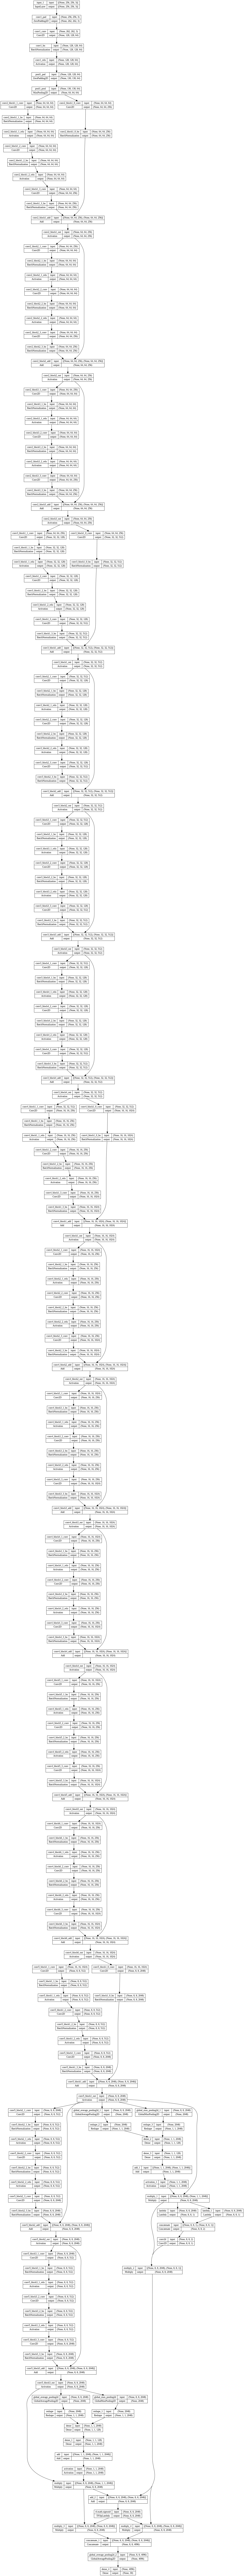

In [ ]:

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
optim = SGD(learning_rate=0.0001, momentum = 0.9)

model.load_weights("/content/drive/MyDrive/saved_model/AID/modelCAAID50.h5")

In [ ]:
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

csv_path = '/content/data/result/XXX.csv'

In [ ]:
save_weights_path = '/content/drive/MyDrive/saved_model/AID/modelCAAID50.h5'
#You can modify the path by yourself

checkpoint = ModelCheckpoint(save_weights_path, monitor='val_acc', verbose=1,
                             save_weights_only=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=32, verbose=1)
# logging = TensorBoard(log_dir=log_dir, batch_size=batch_size)
csvlogger = CSVLogger(csv_path, append=True)

callbacks = [checkpoint, reduce_lr, csvlogger]

num_epochs = 100

model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks,
          validation_data=val_generator,
          validation_steps=len(val_generator),
          workers=1)

In [ ]:
_, acc = model.evaluate(val_generator)
print("Test Accuracy: {}%".format(acc*100))

125/125 [==============================] - 33s 252ms/step - loss: 0.1482 - acc: 0.9690
Test Accuracy: 96.8999981880188%


In [ ]:
test_score = model.evaluate_generator(val_generator, batch_size)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

<ipython-input-42-f98d13d09986>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = model.evaluate_generator(val_generator, batch_size)


[INFO] accuracy: 99.61%
[INFO] Loss:  0.017696497961878777


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.figure(figsize=(20,20))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=21)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xticks(rotation=90)
    plt.xlabel('Predicted label')

<ipython-input-25-acbf4290fc56>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(val_generator)


Confusion Matrix
Normalized confusion matrix


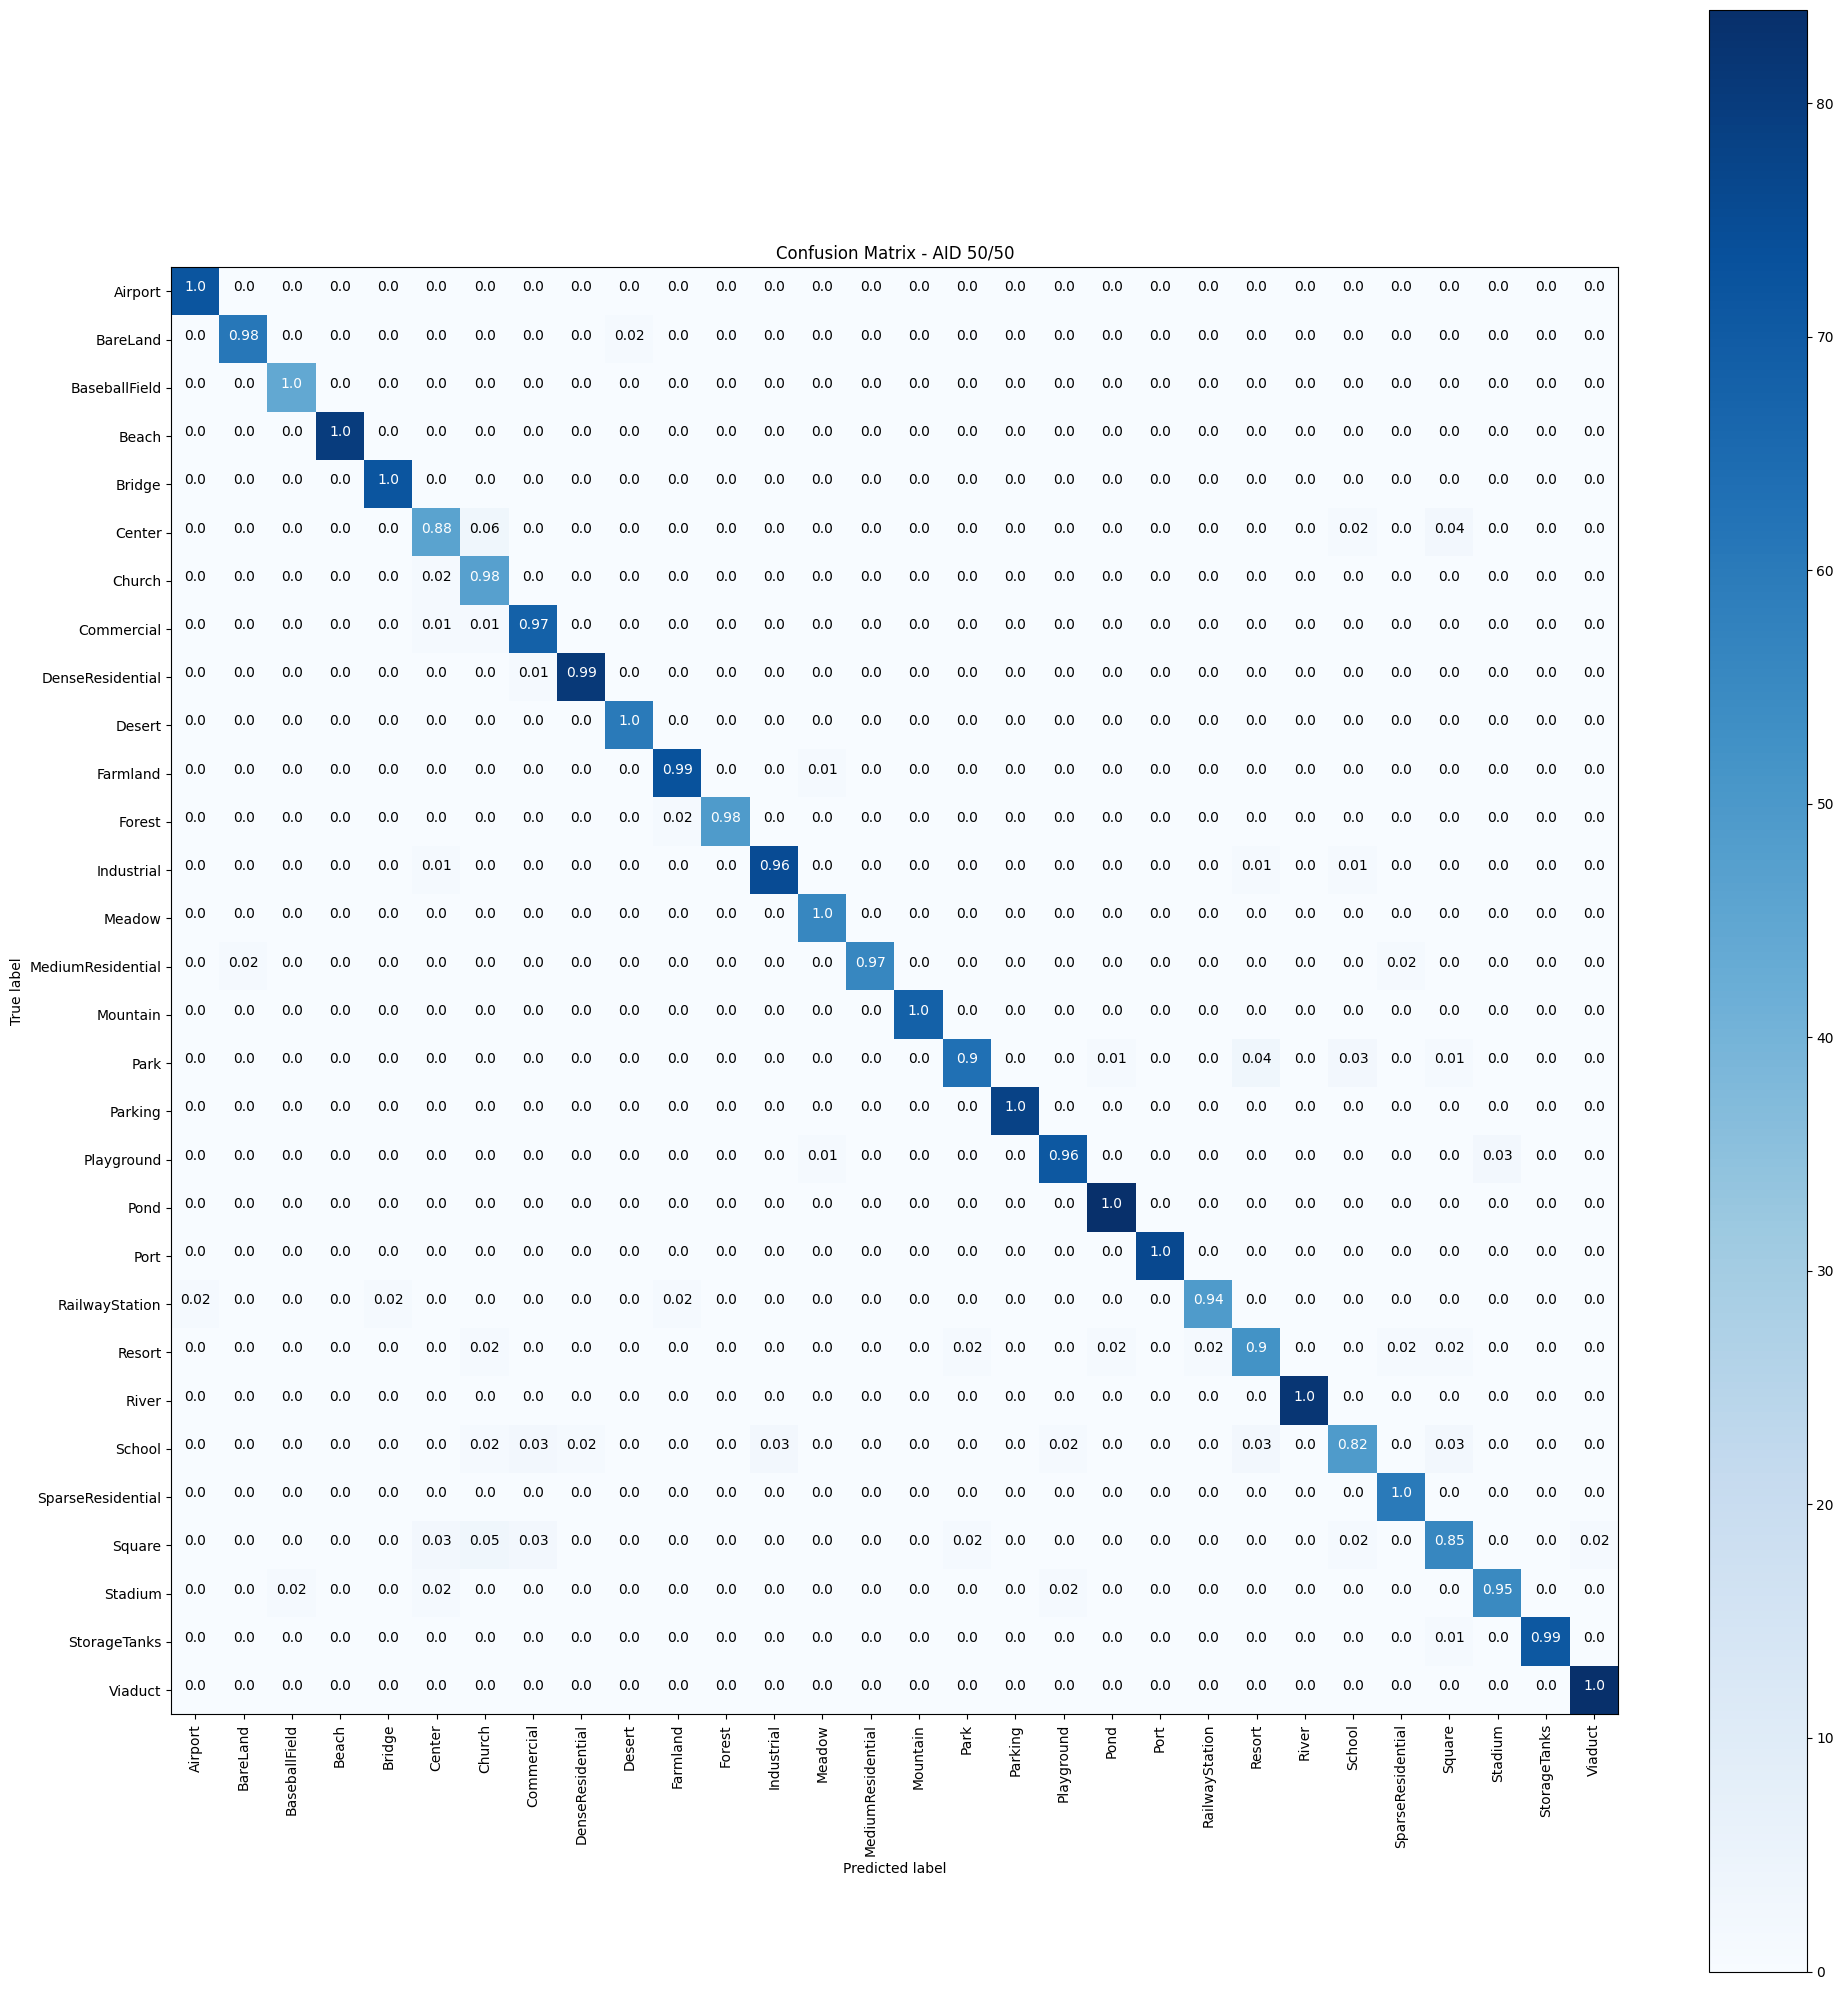

In [ ]:
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#shuffle=False
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(val_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix - AID 50/50')


In [ ]:
clsf_report = pd.DataFrame(classification_report(val_generator.classes, y_pred, target_names=target_names, output_dict=True)).transpose()
print(clsf_report.to_csv('/content/data/result/clsf_report.csv', index= True))

In [ ]:
print(clsf_report)

In [ ]:
layer_names = [layer.name for layer in model.layers]
layer_names

In [ ]:
import os

image_directory = '/content/data/flow/test'  # Replace with the directory path where your images are stored
class_names = sorted(os.listdir(image_directory))  # Assumes the directory names represent the class names

labels = []
for class_index, class_name in enumerate(class_names):
    class_path = os.path.join(image_directory, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        labels.extend([class_index] * len(images))

labels = np.array(labels)


In [ ]:

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf


# Extract feature vectors
model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d_2').output)
feature_vectors = model.predict(val_generator)  # Use your validation or test set here

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_vectors = tsne.fit_transform(feature_vectors)
labels = labels
unique_labels = np.unique(labels)
num_labels = len(unique_labels)
print(num_labels)
num_colors = 30

color_names = [
    "Aqua", "Blue", "Chartreuse", "Crimson", "Cyan", "DarkBlue", "DarkCyan",
    "DarkGoldenrod", "DarkGray", "DarkGreen", "DarkKhaki", "DarkMagenta",
    "DarkOliveGreen", "DarkOrange", "DarkOrchid", "DarkRed", "DarkSalmon",
    "DarkSeaGreen", "DarkSlateBlue", "DarkTurquoise", "DarkViolet", "DeepPink",
    "DeepSkyBlue", "DodgerBlue", "ForestGreen", "Fuchsia", "Gold", "Green",
    "HotPink", "IndianRed"
]


125/125 [==============================] - 35s 272ms/step
30


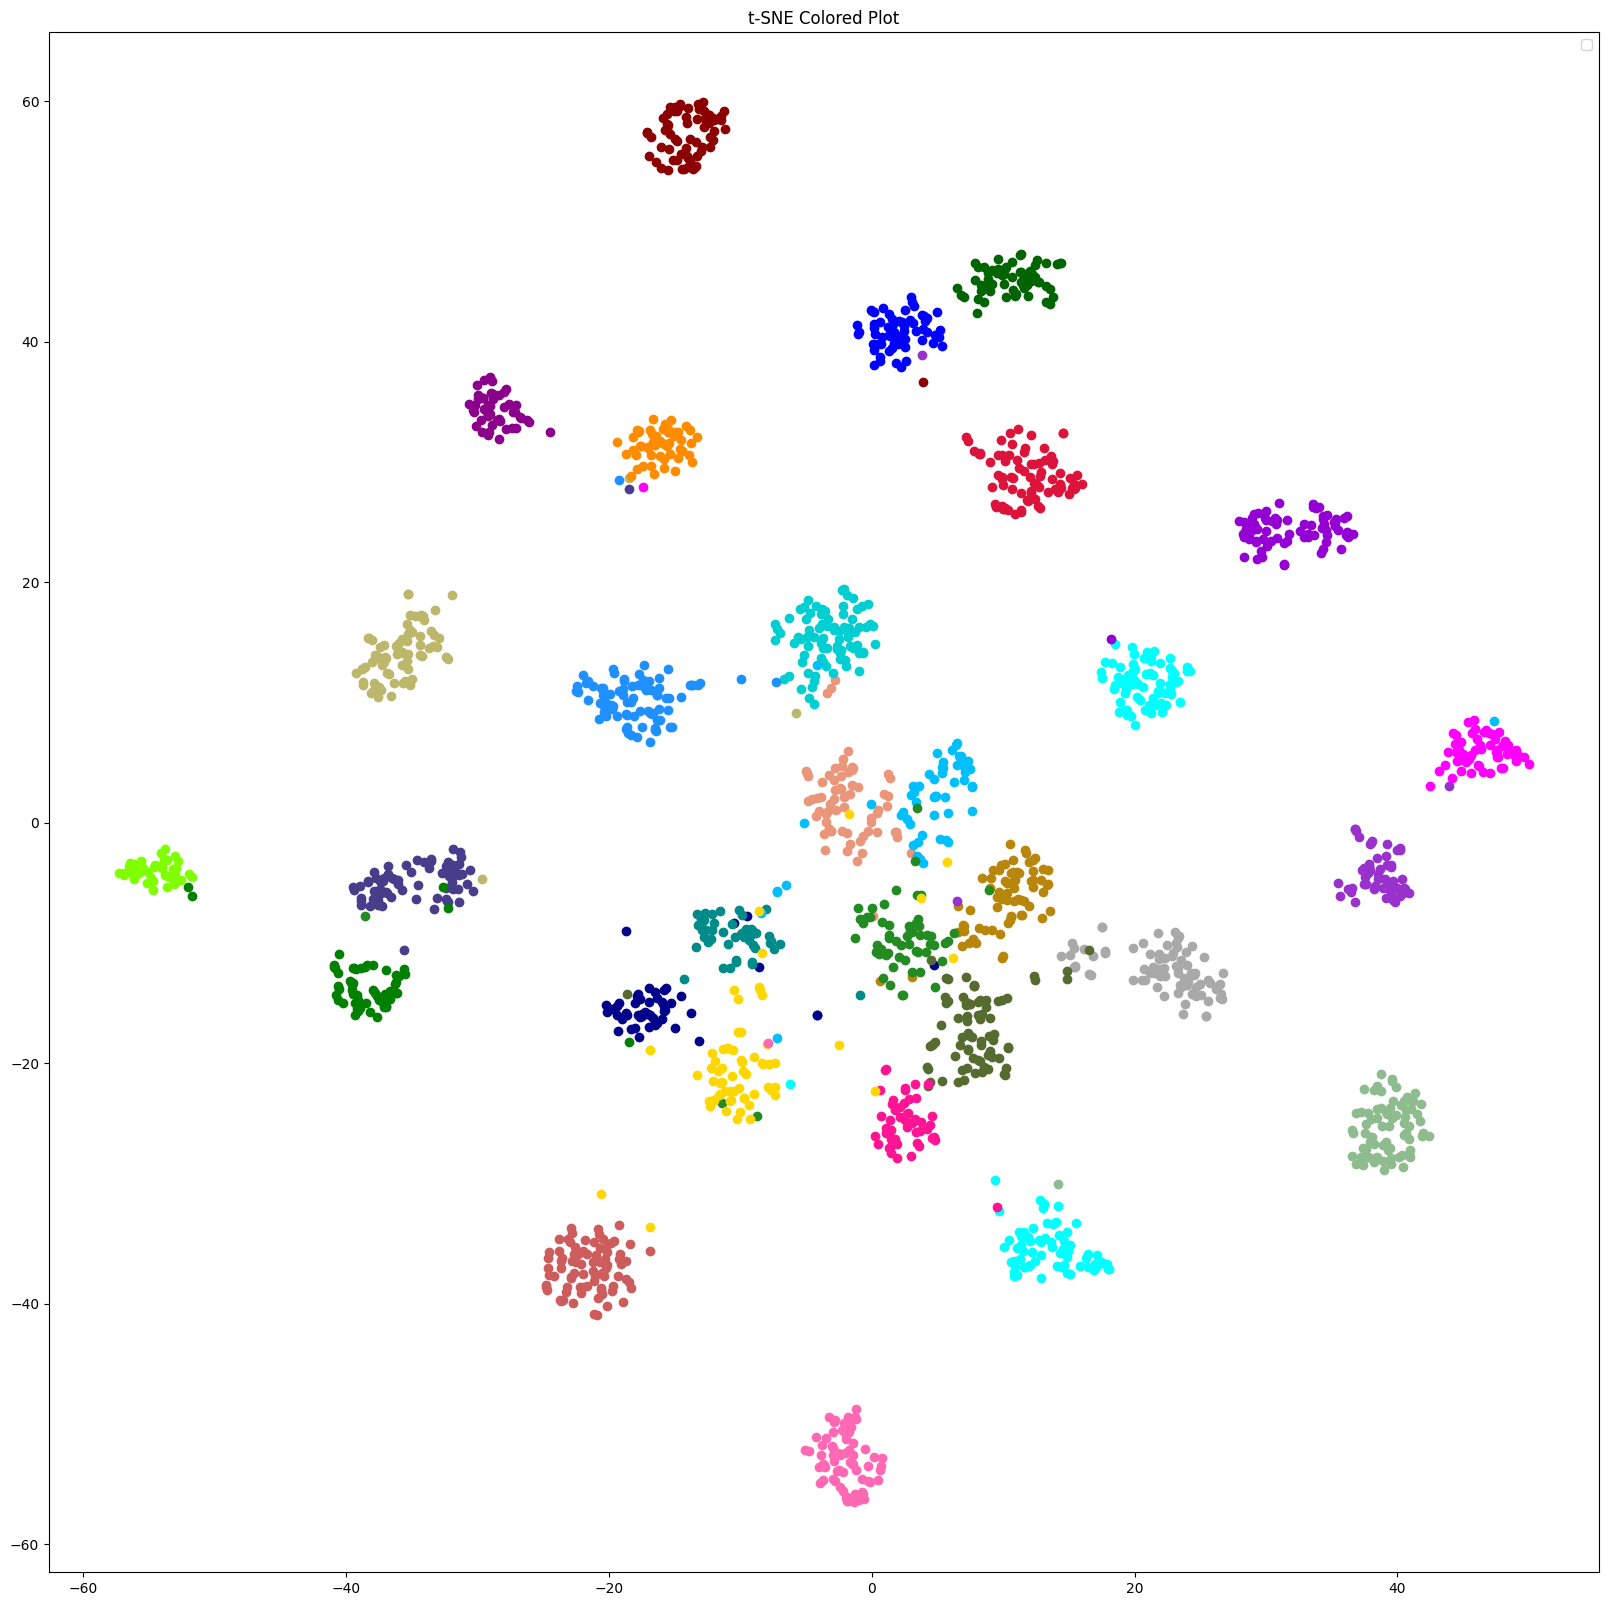

In [ ]:
plt.figure(figsize=(20, 20))
for i, label in enumerate(range(30)):
    indices = np.where(labels == label)[0]
    color = color_names[i % len(color_names)]  # Select color cyclically
    classname = class_names[label]
    plt.scatter(tsne_vectors[indices, 0], tsne_vectors[indices, 1], color=color)

plt.title('t-SNE Colored Plot')
plt.legend()
plt.show()

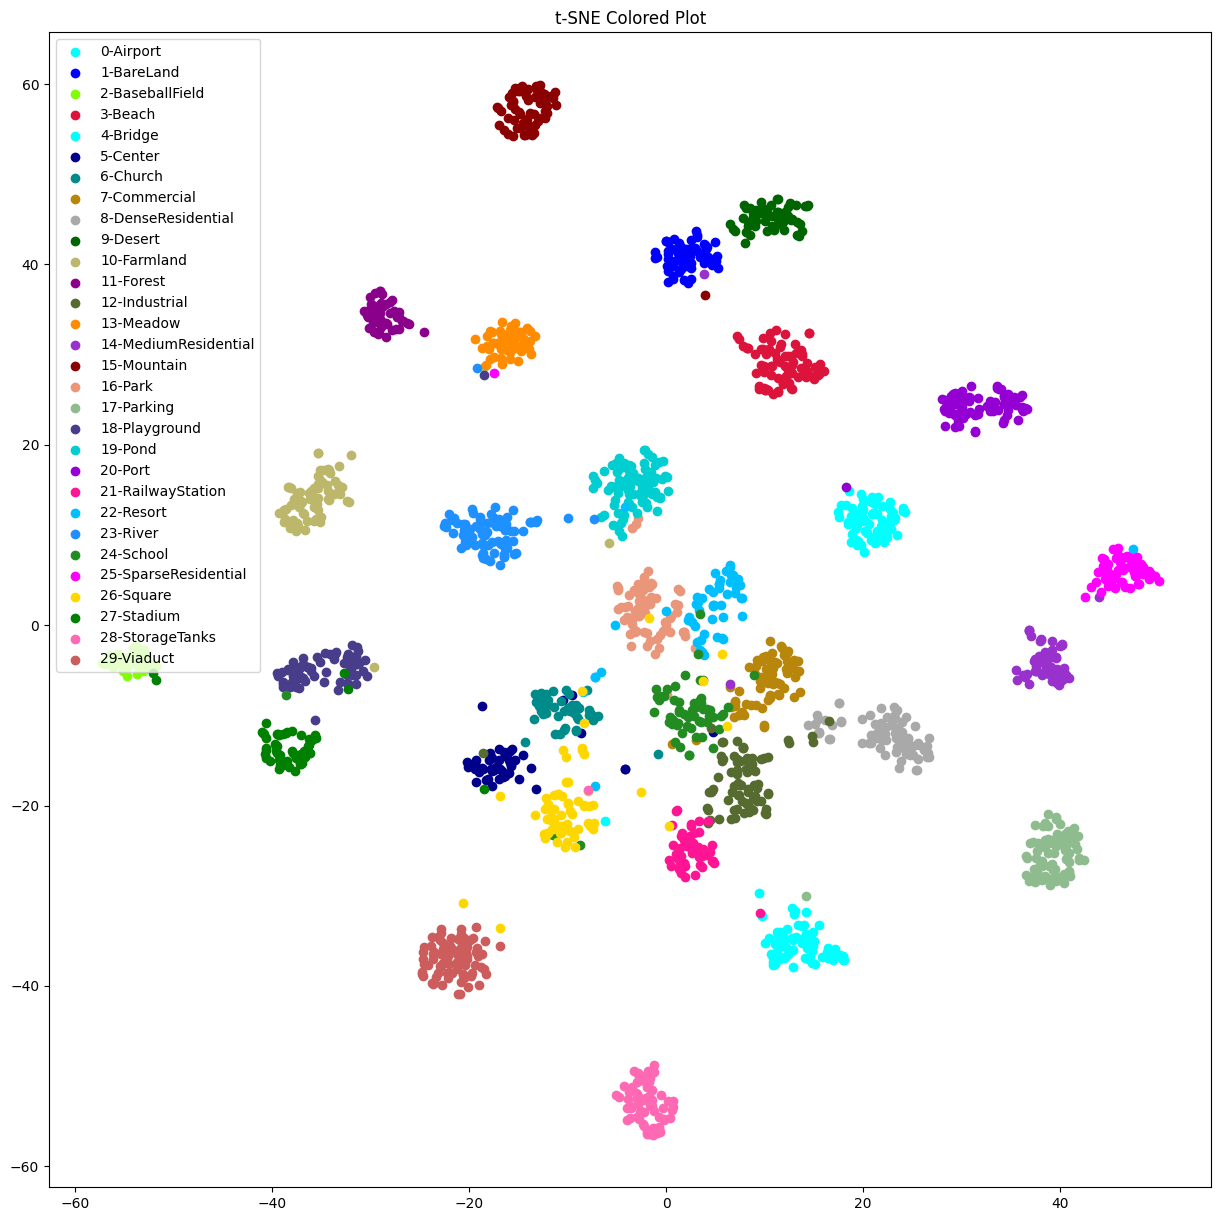

In [ ]:
plt.figure(figsize=(15, 15))
for i, label in enumerate(range(30)):
    indices = np.where(labels == label)[0]
    color = color_names[i % len(color_names)]  # Select color cyclically
    classname = class_names[label]
    plt.scatter(tsne_vectors[indices, 0], tsne_vectors[indices, 1], color=color, label=f'{label}-{class_names[i]}')


plt.title('t-SNE Colored Plot')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
def grad_cam(input_model, x, layer_name, class_index):
    model = input_model

    # Get the target layer output tensor
    target_layer = model.get_layer(layer_name)
    target_layer_output = target_layer.output

    # Calculate the gradients of the target class with respect to the target layer output
    grads = tf.gradients(model.output[:, class_index], target_layer_output)[0]

    # Calculate the global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Access the values of the target layer output and gradients
    sess = tf.compat.v1.keras.backend.get_session()
    target_layer_output_value, pooled_grads_value = sess.run([target_layer_output, pooled_grads], feed_dict={model.input: x})

    # Multiply each channel in the target layer output by its corresponding gradient value
    for i in range(target_layer_output_value.shape[-1]):
        target_layer_output_value[:, :, :, i] *= pooled_grads_value[i]

    # Average the weighted target layer output to get the Grad-CAM heatmap
    grad_cam = np.mean(target_layer_output_value, axis=-1)

    # Apply ReLU activation and normalize the heatmap between 0 and 1
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam /= np.max(grad_cam)

    return grad_cam



# Load the pre-trained ResNet50 model
#model.load_weights("/content/drive/MyDrive/saved_model/AID/modelAID50.h5")
#model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])


# Define the layer name and target class index


In [ ]:
resize_fn = tf.keras.layers.experimental.preprocessing.Resizing(*resize_dim, interpolation='bilinear')
resized_heatmap = resize_fn(resized_heatmap)
resized_heatmap = resized_heatmap.numpy()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
def grad_cam(input_model, x, layer_name, class_index):
    model = input_model

    # Get the target layer output tensor
    target_layer = model.get_layer(layer_name)
    target_layer_output = target_layer.output

    # Calculate the gradients of the target class with respect to the target layer output
    grads = tf.gradients(model.output[:, class_index], target_layer_output)[0]

    # Calculate the global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Access the values of the target layer output and gradients
    sess = tf.compat.v1.keras.backend.get_session()
    target_layer_output_value, pooled_grads_value = sess.run([target_layer_output, pooled_grads], feed_dict={model.input: x})

    # Multiply each channel in the target layer output by its corresponding gradient value
    for i in range(target_layer_output_value.shape[-1]):
        target_layer_output_value[:, :, :, i] *= pooled_grads_value[i]

    # Average the weighted target layer output to get the Grad-CAM heatmap
    grad_cam = np.mean(target_layer_output_value, axis=-1)

    # Apply ReLU activation and normalize the heatmap between 0 and 1
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam /= np.max(grad_cam)

    return grad_cam



# Load the pre-trained ResNet50 model
model.load_weights("/content/drive/MyDrive/saved_model/AID/modelCAAID50.h5")
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])


# Define the layer name and target class index
layer_name = 'multiply_14'
target_class_index = 25 # Example class index for 'zebra'

# Load and preprocess the image
image_path = '/content/data/AID/SparseResidential/sparseresidential_125.jpg'


img = plt.imread(image_path)
x = preprocess_image(image_path)

# Resize the image to the desired size


resize_dim = (256, 256)  # Replace with the desired resize dimensions
resized_img = tf.image.resize(x, resize_dim).eval(session=tf.compat.v1.keras.backend.get_session())[0]

# Generate Grad-CAM heatmap
heatmap = grad_cam(model, x, layer_name, target_class_index)

# Resize the heatmap to match the resized image size
resized_heatmap = tf.image.resize(heatmap[..., np.newaxis], resize_dim, method='bilinear').eval(session=tf.compat.v1.keras.backend.get_session())

# Convert the heatmap to grayscale and normalize between 0 and 1
heatmap_gray = resized_heatmap[..., 0]
heatmap_gray = (heatmap_gray - np.min(heatmap_gray)) / (np.max(heatmap_gray) - np.min(heatmap_gray))

# Overlay the heatmap on the resized image
heatmap_rgb = plt.cm.jet(heatmap_gray.squeeze())[..., :3]  # Apply color map

# Display the resized image and the overlaid heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(resized_img)
axes[1].imshow(heatmap_rgb, alpha=0.6)
axes[1].axis('off')
axes[1].set_title('Grad CAM')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
def grad_cam(input_model, x, layer_name, class_index):
    model = input_model

    # Get the target layer output tensor
    target_layer = model.get_layer(layer_name)
    target_layer_output = target_layer.output

    # Calculate the gradients of the target class with respect to the target layer output
    grads = tf.gradients(model.output[:, class_index], target_layer_output)[0]

    # Calculate the global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Access the values of the target layer output and gradients
    sess = tf.compat.v1.keras.backend.get_session()
    target_layer_output_value, pooled_grads_value = sess.run([target_layer_output, pooled_grads], feed_dict={model.input: x})

    # Multiply each channel in the target layer output by its corresponding gradient value
    for i in range(target_layer_output_value.shape[-1]):
        target_layer_output_value[:, :, :, i] *= pooled_grads_value[i]

    # Average the weighted target layer output to get the Grad-CAM heatmap
    grad_cam = np.mean(target_layer_output_value, axis=-1)

    # Apply ReLU activation and normalize the heatmap between 0 and 1
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam /= np.max(grad_cam)

    return grad_cam



# Load the pre-trained ResNet50 model
model.load_weights("/content/drive/MyDrive/saved_model/AID/modelCAAID50.h5")
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])


# Define the layer name and target class index
layer_name = 'multiply_13'
target_class_index = 25 # Example class index for 'zebra'

# Load and preprocess the image
image_path = '/content/data/AID/SparseResidential/sparseresidential_125.jpg'

img = plt.imread(image_path)
x = preprocess_image(image_path)

# Resize the image to the desired size


resize_dim = (256, 256)  # Replace with the desired resize dimensions
resized_img = tf.image.resize(x, resize_dim).eval(session=tf.compat.v1.keras.backend.get_session())[0]

# Generate Grad-CAM heatmap
heatmap = grad_cam(model, x, layer_name, target_class_index)

# Resize the heatmap to match the resized image size
resized_heatmap = tf.image.resize(heatmap[..., np.newaxis], resize_dim, method='bilinear').eval(session=tf.compat.v1.keras.backend.get_session())

# Convert the heatmap to grayscale and normalize between 0 and 1
heatmap_gray = resized_heatmap[..., 0]
heatmap_gray = (heatmap_gray - np.min(heatmap_gray)) / (np.max(heatmap_gray) - np.min(heatmap_gray))

# Overlay the heatmap on the resized image
heatmap_rgb = plt.cm.jet(heatmap_gray.squeeze())[..., :3]  # Apply color map

# Display the resized image and the overlaid heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(resized_img)
axes[1].imshow(heatmap_rgb, alpha=0.6)
axes[1].axis('off')
axes[1].set_title('Grad CAM')
plt.show()

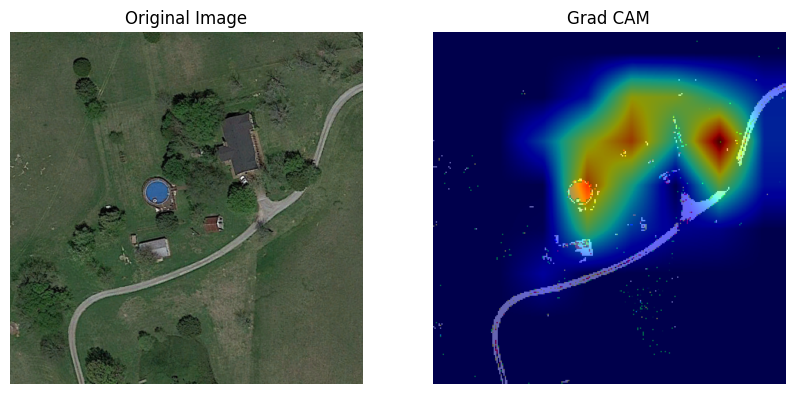

In [ ]:
layer_name = 'multiply_12'
target_class_index = 25  # Example class index for 'zebra'

# Load and preprocess the image
image_path = '/content/data/AID/SparseResidential/sparseresidential_125.jpg'
img = plt.imread(image_path)
x = preprocess_image(image_path)

# Resize the image to the desired size


resize_dim = (256, 256)  # Replace with the desired resize dimensions
resized_img = tf.image.resize(x, resize_dim).eval(session=tf.compat.v1.keras.backend.get_session())[0]

# Generate Grad-CAM heatmap
heatmap = grad_cam(model, x, layer_name, target_class_index)

# Resize the heatmap to match the resized image size
resized_heatmap = tf.image.resize(heatmap[..., np.newaxis], resize_dim, method='bilinear').eval(session=tf.compat.v1.keras.backend.get_session())

# Convert the heatmap to grayscale and normalize between 0 and 1
heatmap_gray = resized_heatmap[..., 0]
heatmap_gray = (heatmap_gray - np.min(heatmap_gray)) / (np.max(heatmap_gray) - np.min(heatmap_gray))

# Overlay the heatmap on the resized image
heatmap_rgb = plt.cm.jet(heatmap_gray.squeeze())[..., :3]  # Apply color map

# Display the resized image and the overlaid heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(resized_img)
axes[1].imshow(heatmap_rgb, alpha=0.6)
axes[1].axis('off')
axes[1].set_title('Grad CAM')
plt.show()

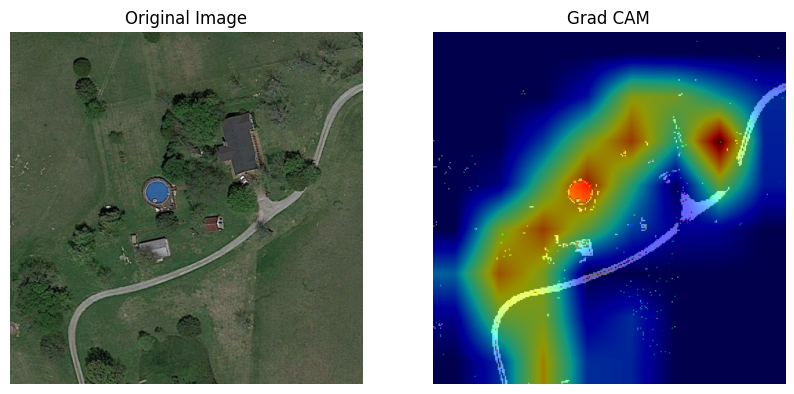

In [ ]:
layer_name = 'multiply_11'
target_class_index = 25 # Example class index for 'zebra'

# Load and preprocess the image
image_path = '/content/data/AID/SparseResidential/sparseresidential_125.jpg'
img = plt.imread(image_path)
x = preprocess_image(image_path)

# Resize the image to the desired size


resize_dim = (256, 256)  # Replace with the desired resize dimensions
resized_img = tf.image.resize(x, resize_dim).eval(session=tf.compat.v1.keras.backend.get_session())[0]

# Generate Grad-CAM heatmap
heatmap = grad_cam(model, x, layer_name, target_class_index)

# Resize the heatmap to match the resized image size
resized_heatmap = tf.image.resize(heatmap[..., np.newaxis], resize_dim, method='bilinear').eval(session=tf.compat.v1.keras.backend.get_session())

# Convert the heatmap to grayscale and normalize between 0 and 1
heatmap_gray = resized_heatmap[..., 0]
heatmap_gray = (heatmap_gray - np.min(heatmap_gray)) / (np.max(heatmap_gray) - np.min(heatmap_gray))

# Overlay the heatmap on the resized image
heatmap_rgb = plt.cm.jet(heatmap_gray.squeeze())[..., :3]  # Apply color map

# Display the resized image and the overlaid heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(resized_img)
axes[1].imshow(heatmap_rgb, alpha=0.6)
axes[1].axis('off')
axes[1].set_title('Grad CAM')
plt.show()

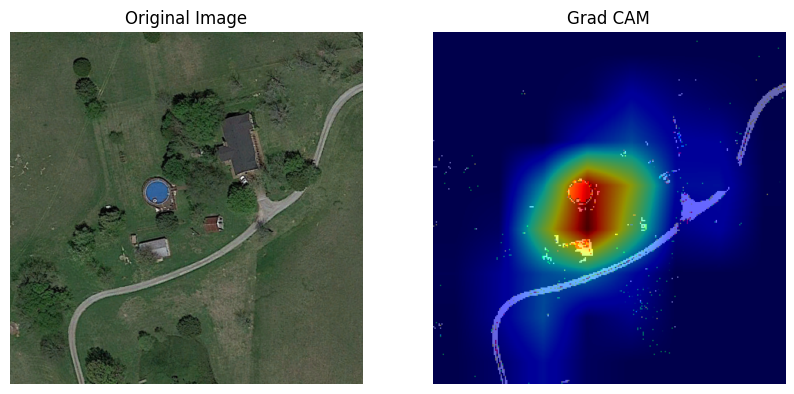

In [ ]:
layer_name = 'multiply_10'
target_class_index = 25  # Example class index for 'zebra'

# Load and preprocess the image
image_path = '/content/data/AID/SparseResidential/sparseresidential_125.jpg'

img = plt.imread(image_path)
x = preprocess_image(image_path)

# Resize the image to the desired size


resize_dim = (256, 256)  # Replace with the desired resize dimensions
resized_img = tf.image.resize(x, resize_dim).eval(session=tf.compat.v1.keras.backend.get_session())[0]

# Generate Grad-CAM heatmap
heatmap = grad_cam(model, x, layer_name, target_class_index)

# Resize the heatmap to match the resized image size
resized_heatmap = tf.image.resize(heatmap[..., np.newaxis], resize_dim, method='bilinear').eval(session=tf.compat.v1.keras.backend.get_session())

# Convert the heatmap to grayscale and normalize between 0 and 1
heatmap_gray = resized_heatmap[..., 0]
heatmap_gray = (heatmap_gray - np.min(heatmap_gray)) / (np.max(heatmap_gray) - np.min(heatmap_gray))

# Overlay the heatmap on the resized image
heatmap_rgb = plt.cm.jet(heatmap_gray.squeeze())[..., :3]  # Apply color map

# Display the resized image and the overlaid heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(resized_img)
axes[1].imshow(heatmap_rgb, alpha=0.6)
axes[1].axis('off')
axes[1].set_title('Grad CAM')
plt.show()

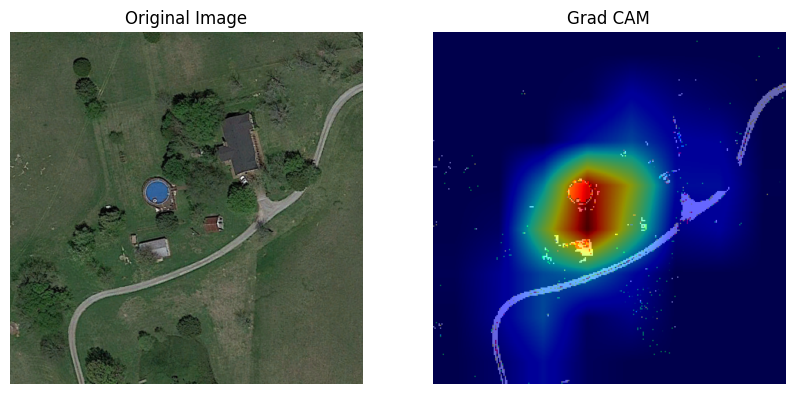

In [ ]:
layer_name = 'conv5_block3_out'
target_class_index = 25 # Example class index for 'zebra'

# Load and preprocess the image
image_path = '/content/data/AID/SparseResidential/sparseresidential_125.jpg'

img = plt.imread(image_path)
x = preprocess_image(image_path)

# Resize the image to the desired size


resize_dim = (256, 256)  # Replace with the desired resize dimensions
resized_img = tf.image.resize(x, resize_dim).eval(session=tf.compat.v1.keras.backend.get_session())[0]

# Generate Grad-CAM heatmap
heatmap = grad_cam(model, x, layer_name, target_class_index)

# Resize the heatmap to match the resized image size
resized_heatmap = tf.image.resize(heatmap[..., np.newaxis], resize_dim, method='bilinear').eval(session=tf.compat.v1.keras.backend.get_session())

# Convert the heatmap to grayscale and normalize between 0 and 1
heatmap_gray = resized_heatmap[..., 0]
heatmap_gray = (heatmap_gray - np.min(heatmap_gray)) / (np.max(heatmap_gray) - np.min(heatmap_gray))

# Overlay the heatmap on the resized image
heatmap_rgb = plt.cm.jet(heatmap_gray.squeeze())[..., :3]  # Apply color map

# Display the resized image and the overlaid heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(resized_img)
axes[1].imshow(heatmap_rgb, alpha=0.6)
axes[1].axis('off')
axes[1].set_title('Grad CAM')
plt.show()

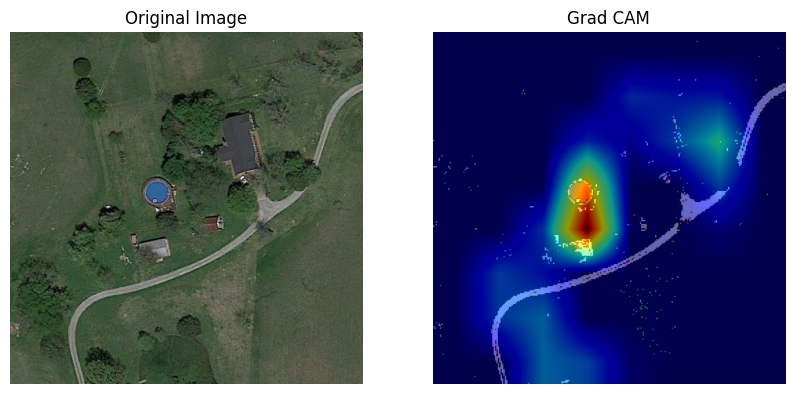

In [ ]:
layer_name = 'conv5_block1_out'
target_class_index = 25  # Example class index for 'zebra'

# Load and preprocess the image
image_path = '/content/data/AID/SparseResidential/sparseresidential_125.jpg'
img = plt.imread(image_path)
x = preprocess_image(image_path)

# Resize the image to the desired size


resize_dim = (256, 256)  # Replace with the desired resize dimensions
resized_img = tf.image.resize(x, resize_dim).eval(session=tf.compat.v1.keras.backend.get_session())[0]

# Generate Grad-CAM heatmap
heatmap = grad_cam(model, x, layer_name, target_class_index)

# Resize the heatmap to match the resized image size
resized_heatmap = tf.image.resize(heatmap[..., np.newaxis], resize_dim, method='bilinear').eval(session=tf.compat.v1.keras.backend.get_session())

# Convert the heatmap to grayscale and normalize between 0 and 1
heatmap_gray = resized_heatmap[..., 0]
heatmap_gray = (heatmap_gray - np.min(heatmap_gray)) / (np.max(heatmap_gray) - np.min(heatmap_gray))

# Overlay the heatmap on the resized image
heatmap_rgb = plt.cm.jet(heatmap_gray.squeeze())[..., :3]  # Apply color map

# Display the resized image and the overlaid heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(resized_img)
axes[1].imshow(heatmap_rgb, alpha=0.6)
axes[1].axis('off')
axes[1].set_title('Grad CAM')
plt.show()

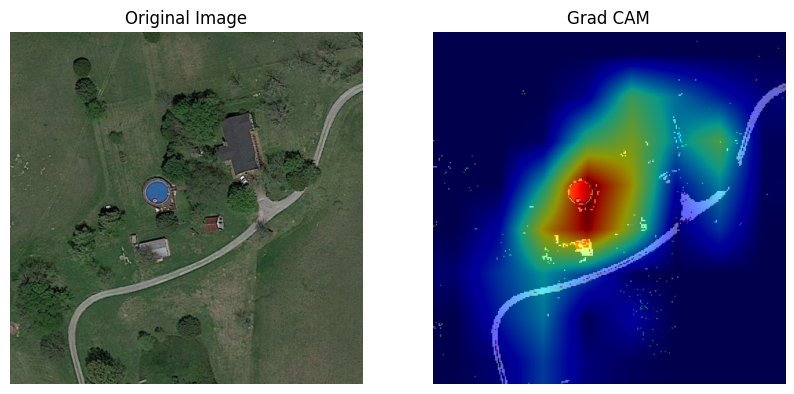

In [ ]:
layer_name = 'add_5'
target_class_index = 25  # Example class index for 'zebra'

# Load and preprocess the image
image_path = '/content/data/AID/SparseResidential/sparseresidential_125.jpg'
img = plt.imread(image_path)
x = preprocess_image(image_path)

# Resize the image to the desired size


resize_dim = (256, 256)  # Replace with the desired resize dimensions
resized_img = tf.image.resize(x, resize_dim).eval(session=tf.compat.v1.keras.backend.get_session())[0]

# Generate Grad-CAM heatmap
heatmap = grad_cam(model, x, layer_name, target_class_index)

# Resize the heatmap to match the resized image size
resized_heatmap = tf.image.resize(heatmap[..., np.newaxis], resize_dim, method='bilinear').eval(session=tf.compat.v1.keras.backend.get_session())

# Convert the heatmap to grayscale and normalize between 0 and 1
heatmap_gray = resized_heatmap[..., 0]
heatmap_gray = (heatmap_gray - np.min(heatmap_gray)) / (np.max(heatmap_gray) - np.min(heatmap_gray))

# Overlay the heatmap on the resized image
heatmap_rgb = plt.cm.jet(heatmap_gray.squeeze())[..., :3]  # Apply color map

# Display the resized image and the overlaid heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(resized_img)
axes[1].imshow(heatmap_rgb, alpha=0.6)
axes[1].axis('off')
axes[1].set_title('Grad CAM')
plt.show()

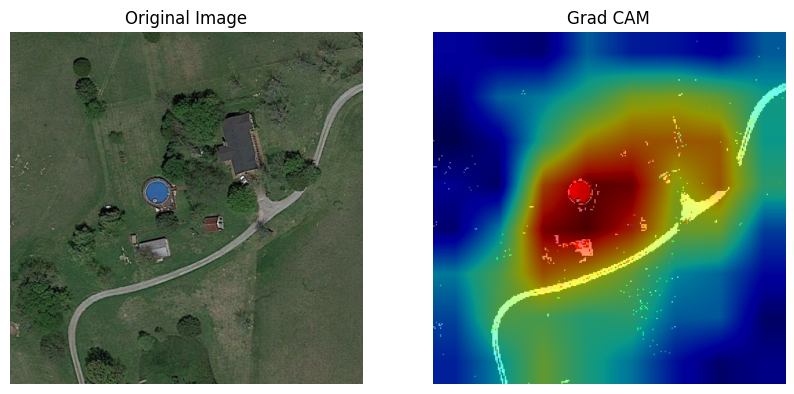

In [ ]:
layer_name = 'tf_op_layer_Sigmoid'
target_class_index = 25  # Example class index for 'zebra'

# Load and preprocess the image
image_path = '/content/data/AID/SparseResidential/sparseresidential_125.jpg'
img = plt.imread(image_path)
x = preprocess_image(image_path)

# Resize the image to the desired size


resize_dim = (256, 256)  # Replace with the desired resize dimensions
resized_img = tf.image.resize(x, resize_dim).eval(session=tf.compat.v1.keras.backend.get_session())[0]

# Generate Grad-CAM heatmap
heatmap = grad_cam(model, x, layer_name, target_class_index)

# Resize the heatmap to match the resized image size
resized_heatmap = tf.image.resize(heatmap[..., np.newaxis], resize_dim, method='bilinear').eval(session=tf.compat.v1.keras.backend.get_session())

# Convert the heatmap to grayscale and normalize between 0 and 1
heatmap_gray = resized_heatmap[..., 0]
heatmap_gray = (heatmap_gray - np.min(heatmap_gray)) / (np.max(heatmap_gray) - np.min(heatmap_gray))

# Overlay the heatmap on the resized image
heatmap_rgb = plt.cm.jet(heatmap_gray.squeeze())[..., :3]  # Apply color map

# Display the resized image and the overlaid heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(resized_img)
axes[1].imshow(heatmap_rgb, alpha=0.6)
axes[1].axis('off')
axes[1].set_title('Grad CAM')
plt.show()

In [ ]:
tf.compat.v1.disable_eager_execution()


In [ ]:
add_8',
 'tf_op_layer_Sigmoid

In [ ]:
!pip install pandas
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_excel('/content/data/result/clsf_report.csv')



In [ ]:


class_names = list(data.keys())[:-3]  # Exclude the average and macro values



['Unnamed: 0', ' precision', 'recall ', ' f1-score       ']

In [ ]:
precision = [data[class_name][' precision'] for class_name in class_names]
recall = [data[class_name]['recall'] for class_name in class_names]
f1_score = [data[class_name]['f1-score'] for class_name in class_names]
support = [data[class_name]['support'] for class_name in class_names]
